CSV file loaded successfully.
Actor vectors created successfully.

Evaluating movie: Toy Story 3
Precision: 0.11
Recall: 0.67
F1 Score: 0.18
Accuracy: 0.10

Evaluating movie: Avengers: Age of Ultron
Precision: 0.18
Recall: 1.00
F1 Score: 0.30
Accuracy: 0.18

Evaluating movie: Cars
Precision: 0.12
Recall: 0.67
F1 Score: 0.21
Accuracy: 0.12

Evaluating movie: Kung Fu Panda 3
Precision: 0.14
Recall: 1.00
F1 Score: 0.25
Accuracy: 0.14

Evaluating movie: Troy
Precision: 0.16
Recall: 1.00
F1 Score: 0.27
Accuracy: 0.16

Evaluation Results:
               Movie Title  Precision  Recall  F1 Score  Accuracy
0              Toy Story 3       0.11    0.67      0.18      0.10
1  Avengers: Age of Ultron       0.18    1.00      0.30      0.18
2                     Cars       0.12    0.67      0.21      0.12
3          Kung Fu Panda 3       0.14    1.00      0.25      0.14
4                     Troy       0.16    1.00      0.27      0.16


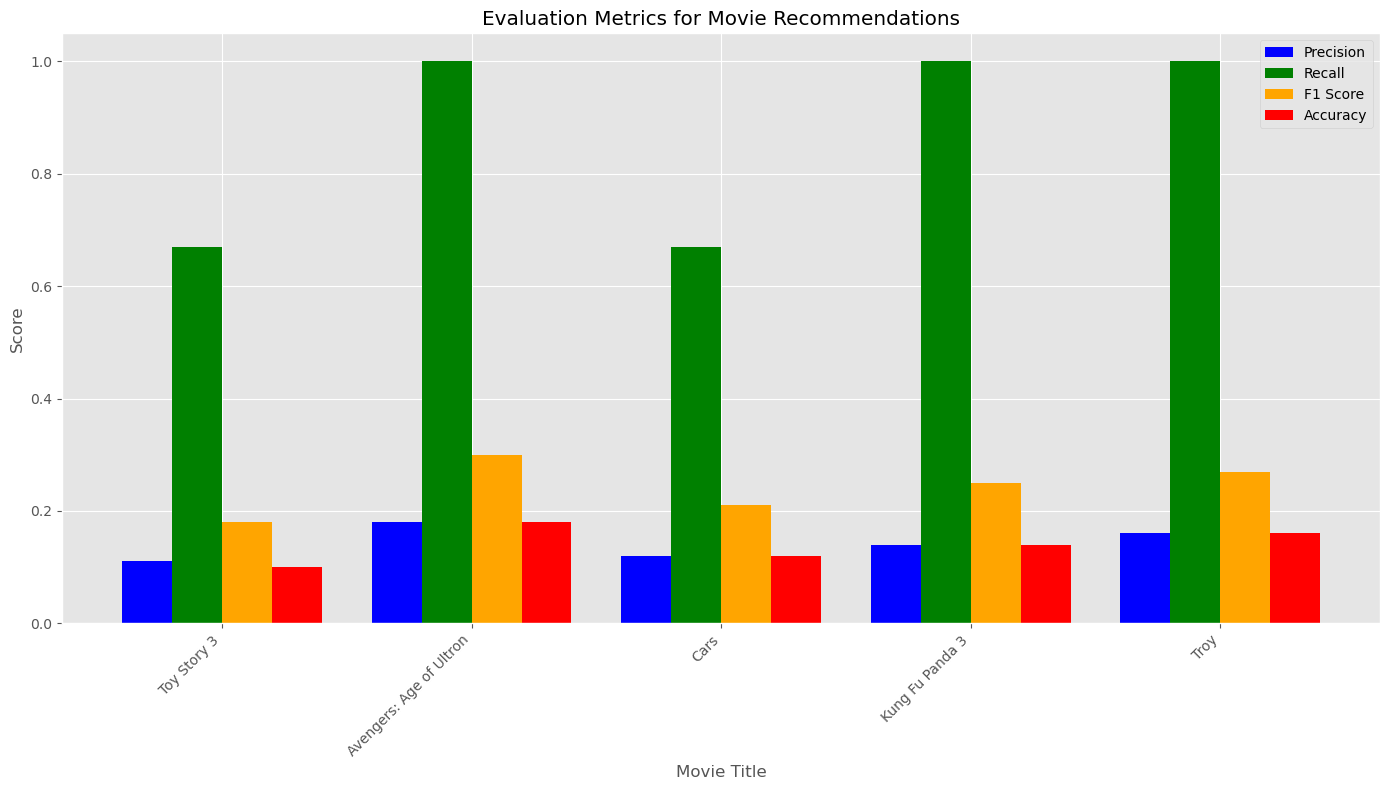

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

# Step 1: Create the Hamming Distance matrix based on actors
def create_hamming_distance():
    try:
        data = pd.read_csv('main_data.csv')  # Ensure the file path is correct
        print("CSV file loaded successfully.")
    except FileNotFoundError as e:
        print(f"Error loading CSV file: {e}")
        return None

    # Combine actor columns into one feature for each movie
    data['actors_combined'] = (data['actor_1_name'].fillna('') + ', ' + 
                               data['actor_2_name'].fillna('') + ', ' + 
                               data['actor_3_name'].fillna('')).str.strip()

    # Get unique actors from the dataset
    unique_actors = set()
    for actors in data['actors_combined']:
        unique_actors.update([actor.strip() for actor in actors.split(', ') if actor.strip()])
    unique_actors = sorted(unique_actors)
    
    # Create binary vectors for each movie
    actor_vectors = []
    for actors in data['actors_combined']:
        movie_vector = [1 if actor in actors.split(', ') else 0 for actor in unique_actors]
        actor_vectors.append(movie_vector)
    
    data['actor_vector'] = actor_vectors
    print("Actor vectors created successfully.")

    return data, unique_actors

# Step 2: Recommendation system based on Hamming Distance
def recommend_movies_by_hamming(movie_title, data, unique_actors):
    movie_title = movie_title.strip().lower()
    data['movie_title'] = data['movie_title'].str.strip().str.lower()

    if movie_title not in data['movie_title'].values:
        return 'Sorry! Try another movie name.', []

    movie_index = data[data['movie_title'] == movie_title].index[0]

    # Extract actor vector for the target movie
    target_vector = data.loc[movie_index, 'actor_vector']
    
    # Compute Hamming distances to all other movies
    hamming_distances = pairwise_distances([target_vector], list(data['actor_vector']), metric='hamming')[0]

    # Sort movies by Hamming distance (ascending, closer distances are more similar)
    sorted_indices = np.argsort(hamming_distances)
    
    recommended_movies = data.iloc[sorted_indices]['movie_title'].tolist()
    recommended_movies = [movie for movie in recommended_movies if movie != movie_title]  # Exclude the target movie

    # Return top 10 recommendations
    return recommended_movies[:10]

# Step 3: Evaluate the system based on Hamming distance
def evaluate_recommendations_by_hamming(test_cases):
    all_precisions = []
    all_recalls = []
    all_f1_scores = []
    all_accuracies = []
    movies = []

    data, unique_actors = create_hamming_distance()
    if data is None:
        return 'Error: Unable to create data.'

    for movie_title in test_cases:
        print(f"\nEvaluating movie: {movie_title}")

        rec_movies = recommend_movies_by_hamming(movie_title, data, unique_actors)
        if isinstance(rec_movies, str):
            print(f"Error: {rec_movies}")
            continue

        # Extract relevant actors from the target movie
        movie_index = data[data['movie_title'].str.lower() == movie_title.lower()].index[0]
        relevant_actors = set(data.loc[movie_index, 'actors_combined'].split(', '))
        
        all_recommended_actors = set()
        for movie in rec_movies:
            movie_data = data[data['movie_title'].str.lower() == movie.lower()]
            if not movie_data.empty:
                all_recommended_actors.update(set([actor.strip() for actor in movie_data['actors_combined'].values[0].split(', ') if actor.strip()]))

        # Calculate Precision, Recall, F1, Accuracy
        true_positives = len(relevant_actors & all_recommended_actors)
        false_positives = len(all_recommended_actors - relevant_actors)
        false_negatives = len(relevant_actors - all_recommended_actors)
        
        precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        accuracy = true_positives / (true_positives + false_positives + false_negatives) if true_positives + false_positives + false_negatives > 0 else 0
        
        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1_scores.append(f1)
        all_accuracies.append(accuracy)
        movies.append(movie_title)

        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1 Score: {f1:.2f}")
        print(f"Accuracy: {accuracy:.2f}")

    results_df = pd.DataFrame({
        'Movie Title': movies,
        'Precision': [round(p, 2) for p in all_precisions],
        'Recall': [round(r, 2) for r in all_recalls],
        'F1 Score': [round(f1, 2) for f1 in all_f1_scores],
        'Accuracy': [round(acc, 2) for acc in all_accuracies]
    })

    print("\nEvaluation Results:")
    print(results_df)

    # Plotting the results
    plot_evaluation_metrics(results_df)

# Test cases
test_cases = [
    'Toy Story 3',
    'Avengers: Age of Ultron',
    'Cars',
    'Kung Fu Panda 3',
    'Troy'
]

evaluate_recommendations_by_hamming(test_cases)
